In [1]:
import random

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
root = '/home/wilsonyan/data/mnist'

In [3]:
batch_size = 32

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dset_train = datasets.MNIST(root, train=True, download=True, transform=transform)
dset_test = datasets.MNIST(root, train=False, download=True, transform=transform)

loader_train = data.DataLoader(dset_train, batch_size=batch_size, shuffle=True)
loader_test = data.DataLoader(dset_test, batch_size=batch_size, shuffle=True)

In [5]:
def squash(x, dim=-1):
    norm_squared = torch.sum(x ** 2, dim, keepdim=True)
    x = norm_squared / (1 + norm_squared) * x / torch.sqrt(norm_squared)
    return x

In [6]:
def margin_loss(out, y):
    pred = torch.sqrt((out ** 2).sum(-1))
    loss = y * F.relu(0.9 - pred) ** 2 + 0.5 * (1 - y) * F.relu(pred - 0.1) ** 2
    return loss.sum()

In [7]:
def mse_loss(out, y):
    return torch.sum((out - y) ** 2) / batch_size

In [8]:
def softmax(input, dim=1):
    input_size = input.size()
    
    trans_input = input.transpose(dim, len(input_size)-1)
    trans_size = trans_input.size()

    input_2d = trans_input.contiguous().view(-1, trans_size[-1])
    
    soft_max_2d = F.softmax(input_2d)
    
    soft_max_nd = soft_max_2d.view(*trans_size)
    return soft_max_nd.transpose(dim, len(input_size)-1)

In [9]:
class PrimaryCaps(nn.Module):
    def __init__(self, n_dim):
        super(PrimaryCaps, self).__init__()
        self.n_dim = n_dim
        self.conv = nn.Conv2d(256, 32 * 8, 9, stride=2)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1, self.n_dim)
        x = squash(x)
        return x

In [10]:
class DigitCaps(nn.Module):
    def __init__(self, n_dim, prev_dim, n_iter):
        super(DigitCaps, self).__init__()
        self.n_dim = n_dim
        self.prev_dim = prev_dim
        self.n_iter = n_iter
        self.weights = nn.Parameter(torch.randn(10, 6 * 6 * 32, prev_dim, n_dim))
    
    def forward(self, x):
        x = x.unsqueeze(0).unsqueeze(3)
        u_hat = torch.matmul(x, self.weights.unsqueeze(1))
        
        b = Variable(torch.zeros(*u_hat.size()))
        for i in range(self.n_iter):
            
            c = softmax(b, dim=2)
            s = (u_hat * c).sum(2, keepdim=True)
            v = squash(s)
            
            if i < self.n_iter - 1:
                b = b + (u_hat * v).sum(-1, keepdim=True)
        v = v.squeeze(2).squeeze(2).permute(1, 0, 2).contiguous()
        return v

In [11]:
class CapsuleNet(nn.Module):
    def __init__(self):
        super(CapsuleNet, self).__init__()
        self.conv = nn.Conv2d(1, 256, 9)
        self.primary_caps = PrimaryCaps(8)
        self.digit_caps = DigitCaps(16, 8, 3)
        self.fc1 = nn.Linear(160, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 784)
        
    def forward(self, x, y=None):
        x = F.relu(self.conv(x))
        x = self.primary_caps(x)
        out = self.digit_caps(x)
        
        if not y:
            probs = torch.sqrt((out ** 2).sum(-1))
            _, highest_prob = torch.max(probs, 1)
            mask = Variable(torch.eye(10)).index_select(0, highest_prob)
        else:
            mask = y
        
        x = out * mask.unsqueeze(-1)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        reconstruction = x.view(x.size(0), 1, 28, 28)
        return out, reconstruction

In [12]:
def train(model, optimizer, loader, num_epochs=10, show_every=20):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        print('Epoch %s' % epoch)
        print('=' * 10)
        losses_total, losses_margin, losses_rec = [], [], []
        for i, (x, y) in enumerate(iter(loader)):
            y_one_hot = torch.FloatTensor(y.size()[0], 10)
            y_one_hot.zero_()
            y_one_hot.scatter_(1, y.unsqueeze(1), 1)
            x, y_one_hot = Variable(x), Variable(y_one_hot)
            out, reconstruction = model(x)
                        
            loss_margin = margin_loss(out, y_one_hot)
            loss_rec = 0.0005 * mse_loss(x, reconstruction)
            loss = loss_margin + loss_rec
                        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses_total.append(loss.data[0])
            losses_margin.append(loss_margin.data[0])
            losses_rec.append(loss_rec.data[0])
            if i % show_every == 0:
                mean_margin = np.mean(losses_margin[-show_every:])
                mean_rec = np.mean(losses_rec[-show_every:])
                mean_total = np.mean(losses_total[-show_every:])
                print('margin: %s, rec: %s, total: %s' % (mean_margin, mean_rec, mean_total))
            
        print('Mean Loss: %s' % np.mean(losses_total))
    return model

In [13]:
model = CapsuleNet()
optimizer = optim.Adam(model.parameters())

In [14]:
print('Parameters: %s' % sum(param.numel() for param in model.parameters()))

Parameters: 8215568


In [15]:
model = train(model, optimizer, loader_train, num_epochs=10, show_every=100)

Epoch 0
margin: 25.7740592957, rec: 0.473934441805, total: 26.2479934692
margin: 5.71312504292, rec: 0.332280376554, total: 6.0454054141
margin: 2.0734318316, rec: 0.285575132072, total: 2.35900695682
margin: 1.36861261517, rec: 0.277547649741, total: 1.6461602664
margin: 1.18666975006, rec: 0.275384377539, total: 1.46205413103
margin: 0.84353517592, rec: 0.271671359688, total: 1.11520653129
margin: 0.828418945298, rec: 0.269553336948, total: 1.09797228545
margin: 0.812106618583, rec: 0.272488393784, total: 1.08459500879
margin: 0.688119302392, rec: 0.270827197731, total: 0.958946501315
margin: 0.682381867841, rec: 0.267214901447, total: 0.94959676832
margin: 0.572886906005, rec: 0.268224481493, total: 0.841111387908
margin: 0.660376459165, rec: 0.267955389768, total: 0.928331846595
margin: 0.549158719704, rec: 0.267020315975, total: 0.816179033518
margin: 0.637977510467, rec: 0.26841014713, total: 0.906387657523
margin: 0.486984034143, rec: 0.266043851674, total: 0.753027888536
margin

NameError: name 'losses' is not defined

In [24]:
def predict(model, dset):    
    x, y = random.choice(dset)
    x = Variable(x.unsqueeze(0))
    out, reconstruction = model(x)
    prob = torch.sqrt((out ** 2).sum(-1)).squeeze(0)
    _, y_pred = torch.max(prob, 0)
    print('Predict: %s, Actual: %s' % (y_pred.data[0], y))
        
    fig, (ax1, ax2) = plt.subplots(1, 2)
    actual = x.data.squeeze().numpy() * 0.8031 + 0.1307
    ax1.imshow(actual, cmap='gray')
    rec = reconstruction.squeeze().data.numpy() * 0.8031 + 0.1307
    ax2.imshow(rec, cmap='gray')

Predict: 6, Actual: 6


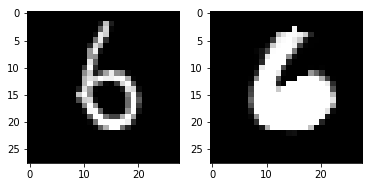

In [42]:
predict(model, dset_test)

In [ ]:
def test_set_accuracy():
    correct = 0
    for i, (x, y) in enumerate(iter(loader_test)):
        x = Variable(x)
        out, _ = model(x)
        prob = torch.sqrt((out ** 2).sum(-1))
        _, y_pred = torch.max(prob, 1)
        correct += y_pred.data.eq(y).sum()
    return correct / len(dset_test)

In [ ]:
print('Accuracy: %s' % test_set_accuracy())